# Pix2Pix - Image to Image Translation

In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from model import Generator as Pix2Pix
from model import *

from dataset import *

In [2]:
torch.__version__

'1.11.0'

In [3]:
os.makedirs("samples", exist_ok=True)

## Hyper Parameters

In [4]:
epoch =0            # "epoch to start training from"
n_epochs = 100      # "number of epochs of training"
batch_size = 32     # "size of the batches"
lr = 0.0002         # "adam: learning rate"
b1 = 0.5            # "adam: decay of first order momentum of gradient"
b2 = 0.999          # "adam: decay of first order momentum of gradient"
n_cpu = 8           # "number of cpu threads to use during batch generation"
img_height = 256     # "size of image height"
img_width = 256      # "size of image width"
channels = 3        # "number of image channels"
sample_interval = 1 # "interval between sampling of images from generators"

## Download Dataset

In [5]:
# !wget -N http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz -O ./datasets/maps.tar.gz
# !mkdir -p ./datasets/maps

# !tar -zxvf ./datasets/maps.tar.gz -C ./datasets/
# !rm ./datasets/maps.tar.gz

## Train Setting

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# imgage size
img_shape = (channels, img_width, img_height)
img_dim = img_width * img_height 

patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)
lambda_pixel = 100

# Dataset
transform = transforms.Compose([
    transforms.Resize((img_width, img_height), transforms.InterpolationMode.BICUBIC),
])

# Data Loader
train_loader = DataLoader(
    dataset=ImageDataset('maps', transforms_=transform, train=True),
    batch_size=batch_size, 
    num_workers=n_cpu,
    shuffle=True
)

val_loader = DataLoader(
    dataset=ImageDataset('maps', transforms_=transform, train=False),
    batch_size=2, 
    num_workers=1,
    shuffle=False
)

In [7]:
test_real_A, test_real_B = next(iter(val_loader))

test_real_A = test_real_A.to(device)
test_real_B = test_real_B.to(device)

test_real_A.shape, test_real_B.shape

(torch.Size([2, 3, 256, 256]), torch.Size([2, 3, 256, 256]))

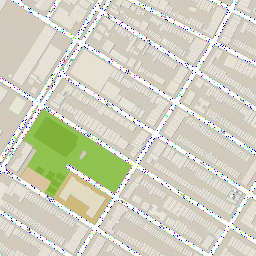

In [8]:
transforms.functional.to_pil_image(test_real_A[0])

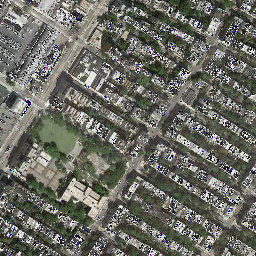

In [9]:
transforms.functional.to_pil_image(test_real_B[0])

## Build network

In [10]:
# build network
generator = Pix2Pix(in_channels=channels, out_channels=3).to(device)
discriminator = Discriminator(in_channels=2*channels).to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss functions
adversarial_loss = nn.MSELoss().to(device)
pixelwise_loss = nn.L1Loss().to(device)

# optimizer
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

## Generator Loss

#### generator loss
1. Generate Random noise z

2. Generator makes fake image using noise z

3. Discriminator evaluate whether this image is fake or real

4. Calculate generator loss

In [11]:
def generator_loss(generator, real_A, real_B):
    valid = torch.ones(real_A.size(0), *patch).to(device)
    
    # Generator loss
    fake_B = generator(real_A)
    pred_fake = discriminator(fake_B, real_A)
    
    adv_loss = adversarial_loss(pred_fake, valid)
    loss_pixel = pixelwise_loss(fake_B, real_B)
    
    return adv_loss + lambda_pixel * loss_pixel

## Discriminator Loss

#### real Loss
1. Discriminator evaluate whether real image is fake or real

2. Calculate fake loss


#### fake Loss
1. Generator makes fake image using Random noise z

2. Discriminator evaluate whether this fake image is fake or real

3. Calculate fake loss

In [12]:
def discriminator_loss(discriminator, real_A, real_B):
    valid = torch.ones(real_A.size(0), *patch).to(device)
    fake = torch.zeros(real_A.size(0), *patch).to(device)
    
    # real Loss
    pred_real = discriminator(real_B, real_A)
    D_real_loss = adversarial_loss(pred_real, valid)

    # fake Loss
    fake_B = generator(real_A)
    pred_fake = discriminator(fake_B, real_A)
    D_fake_loss = adversarial_loss(pred_fake, fake)
    
    return  0.5 * (D_real_loss + D_fake_loss)

## Train

#### Training Process
1. Train Generator
2. Train Discriminator

In [ ]:
for epoch in range(epoch, n_epochs):
    for i, (img1, img2) in enumerate(train_loader):
            
        # Configure input
        real_A = img1.to(device)
        real_B = img2.to(device)

        # ------------------
        #  Train Generators
        # ------------------
        G_optimizer.zero_grad()
        
        G_loss = generator_loss(generator, real_A, real_B) 
        G_loss.backward()
        G_optimizer.step()
    
        # ---------------------
        #  Train Discriminator
        # ---------------------
        D_optimizer.zero_grad()

        D_loss = discriminator_loss(discriminator, real_A, real_B)
        D_loss.backward()
        D_optimizer.step()
        
        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
            % (epoch, n_epochs, i, len(train_loader), D_loss.item(), G_loss.item())
        )
            
            
    # If at sample interval save image
    if epoch % sample_interval == 0:
        with torch.no_grad():
            generated = generator(test_real_A)
            img_sample = torch.cat((test_real_A.data, generated.data, test_real_B.data), -2)
            save_image(img_sample, './samples/sample_' + str(epoch) + '.png', nrow=2, normalize=True)

### Evaluate Generator's fake Image

In [14]:
with torch.no_grad():
    generated = generator(test_real_A)
    img_sample = torch.cat((test_real_A.data, generated.data, test_real_B.data), -2)

    save_image(img_sample, './samples/sample.png', nrow=2, normalize=True)

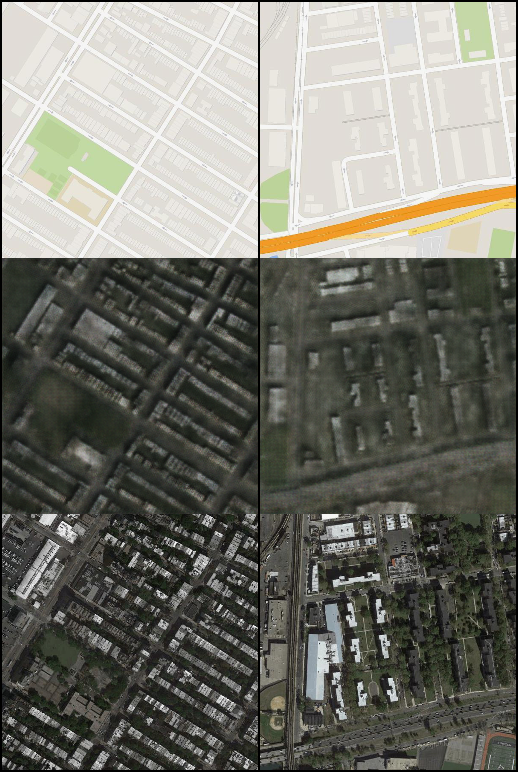

In [14]:
from PIL import Image

Image.open('./samples/sample.png')